## Importing Libraries

In [30]:
import os
import numpy as np
import torch
import glob
import wandb
import cv2 as cv
import math 
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import torch.nn.init
import torch.optim as optim
from torch.nn.functional import batch_norm
import random 
from PIL import Image

### Wandb Login

In [2]:
!wandb login
entity_name="bs20b012"

project_name="CS6910_assignment_2_sweeps"

wandb: Currently logged in as: bs20b012. Use `wandb login --relogin` to force relogin


### Functions

In [28]:
# Train and validation paths defined (dataset is present in local computer with the files located at the following locations)
train_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train'
val_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val'

# Function to display contents
def contents(path):
    for folder in os.listdir(path):
        images=glob.glob((path+'/'+folder+'/*'))
        print("Class:",folder, "total number of images ",len(images))

# Function to display images
def show_image(img_path):
    img=cv.imread(img_path)
    img.shape
    plt.imshow(img)   
    
# Function to calculate maxpool dims
def maxpool_out_dim(input,filter=2,stride=2):
    output_dim=(input-filter)//stride + 1
    return output_dim

# Function to calculate convolution dims
def conv_out_dim(input,filter,stride=1,padding=1):
    output_dim=(input-filter+2*padding)//stride + 1
    return output_dim

### Visualization

In [4]:
contents(val_path)

Class: Amphibia total number pf images  200
Class: Animalia total number pf images  200
Class: Arachnida total number pf images  200
Class: Aves total number pf images  200
Class: Fungi total number pf images  200
Class: Insecta total number pf images  200
Class: Mammalia total number pf images  200
Class: Mollusca total number pf images  200
Class: Plantae total number pf images  200
Class: Reptilia total number pf images  200


In [5]:
contents(train_path)

Class: .DS_Store total number pf images  0
Class: Amphibia total number pf images  1000
Class: Animalia total number pf images  1000
Class: Arachnida total number pf images  1000
Class: Aves total number pf images  1000
Class: Fungi total number pf images  999
Class: Insecta total number pf images  1000
Class: Mammalia total number pf images  1000
Class: Mollusca total number pf images  1000
Class: Plantae total number pf images  1000
Class: Reptilia total number pf images  1000


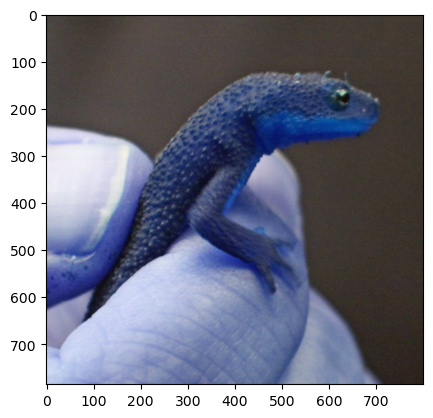

In [6]:
show_image("D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train/Amphibia/1c6fca1eb9840e822d5448ee0e2e837e.jpg")

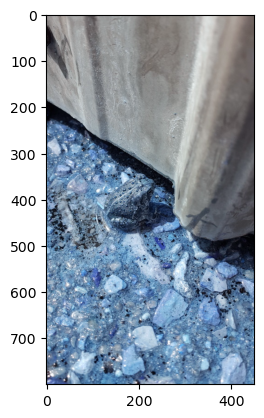

In [7]:
show_image('D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train/Amphibia/015f03767b5fd30019df9ca7720cb869.jpg')

### Data Augmentation class

In [8]:
class data_augmentation():

    def __init__(self,augment=True,batch_size=16):
        self.train_path='D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train'
        self.test_path='D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val'
        self.augment=augment
        self.batch_size=batch_size

    def transform(self,):
        if self.augment==True:
            train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                                   transforms.RandomVerticalFlip(p=0.5),
                                                   transforms.RandomRotation((120)),
                                                   transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.5),
                                                   transforms.Resize((224,224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

            test_transforms = transforms.Compose([transforms.RandomRotation(120),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        else:
            train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

            test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        # Defining the datasets using ImageFolder 
        train_data = datasets.ImageFolder(self.train_path, transform=train_transforms) 
        test_data = datasets.ImageFolder(self.test_path, transform=test_transforms)

        # Variables defined
        num_workers = 0
        valid_size = 0.2
        num_train = len(train_data)
        indices = list(range(num_train))
        num_train_class=1000
        split = int(np.floor(valid_size * num_train_class))
        train_id=[]
        valid_id=[]
        for i in range(10):
            x=i+1
            train_idx, valid_idx = indices[i*1000+split:x*1000], indices[i*1000:i*1000+split]
            train_id=train_id+train_idx
            valid_id=valid_id+valid_idx
            
        # Split the dataset using ids
        train_sampler = SubsetRandomSampler(train_id)
        valid_sampler = SubsetRandomSampler(valid_id)

        # Loading the data
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size,
        sampler=train_sampler, num_workers=num_workers)
        valid_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, 
        num_workers=num_workers)

        return train_loader,valid_loader,test_loader 


In [9]:
# Instance of class data augmentation defined to perform transfromations on dataset
data_prep=data_augmentation()
train_loader,valid_loader,test_loader = data_prep.transform()
test_path='D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val'
root=pathlib.Path(test_path)

# Extracting the class names
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


### Network Defined

In [10]:
class ConvNN(nn.Module):
    def __init__(self, num_filters, kernel_size, activation,dense_dim, input=224,   dropout=0.1, batch_norm=False):
        super(ConvNN,self).__init__()
        self.batch_norm=batch_norm
        self.activation=activation
        self.dense_dim=dense_dim

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=kernel_size[0], stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(224,kernel_size[0])
        w_mpool=maxpool_out_dim(w_conv)
        
        self.conv2 = nn.Conv2d(in_channels=num_filters[0], out_channels=num_filters[1], kernel_size=kernel_size[1], stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[1])
        w_mpool=maxpool_out_dim(w_conv)

        self.conv3 = nn.Conv2d(in_channels=num_filters[1], out_channels=num_filters[2], kernel_size=kernel_size[2], stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=num_filters[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[2])
        w_mpool=maxpool_out_dim(w_conv)

        self.conv4 = nn.Conv2d(in_channels=num_filters[2], out_channels=num_filters[3], kernel_size=kernel_size[3], stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=num_filters[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[3])
        w_mpool=maxpool_out_dim(w_conv)

        self.conv5 = nn.Conv2d(in_channels=num_filters[3], out_channels=num_filters[4], kernel_size=kernel_size[4], stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=num_filters[4])
        self.pool5 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[4])
        w_mpool=maxpool_out_dim(w_conv)
        w_out=num_filters[4]*w_mpool*w_mpool
        self.w_out=w_out

        self.dropout=nn.Dropout(dropout)
        self.Flatten=nn.Flatten(start_dim=1,end_dim=-1)
        self.fc1 = nn.Linear(in_features=w_out, out_features=10)

      
        
    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm==True:
            x = self.bn1(x)
        x = self.activation(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        if self.batch_norm==True:
            x = self.bn2(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = self.dropout(x)

        x = self.conv3(x)
        if self.batch_norm==True:
            x = self.bn3(x)
        x = self.activation(x)
        x = self.pool3(x)
        x = self.dropout(x)

        x = self.conv4(x)
        if self.batch_norm==True:
            x = self.bn4(x)
        x = self.activation(x)
        x = self.pool4(x)
        x = self.dropout(x)

        x = self.conv5(x)
        if self.batch_norm==True:
            x = self.bn5(x)
        x = self.activation(x)
        x = self.pool5(x)
        
        x = x.view(-1,self.w_out)
        x = self.fc1(x)

        return x

### Sweep Configurations

In [11]:
sweep_config = {
    'method': 'bayes', 
    'metric': {
      'name': 'Validation_Accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'num_dense_dim': {
            'values': [64,256]
        },
        'num_filters' : {
           'values' : [[32,32,32,32,32],[32,64,64,128,128],[128,128,64,64,32],[16,32,64,128,256]]
        },
      'kernel_size' : {
         'values' : [[3,5,5,7,7], [7,7,5,3,3], [3,3,3,3,3]]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'activation': {
            'values': ['relu','elu','leaky_relu']
        },
        'batch_norm':{
            'values': [True,False]
        },
        'augment': {
            'values': [True,False]
        },
        'batch_size': {
            'values': [16, 32]
        }
    }
}

### Training Sweep model

In [12]:
def train(kernel_size=[3,3,3,3,3], num_filters=[128,128,64,64,32], dense_dim=64, activation=nn.functional.relu,dropout=0.3,batch_norm=False,augment=True, batch_size=16 ,n_epochs=15,learning_rate= 1e-4):
  
    config_defaults = {
        'num_dense_dim': dense_dim,
        'num_filters' : [128,128,64,64,32],
        'kernel_size' : [3,3,3,3,3],
        'dropout': dropout,
        'learning_rate': learning_rate,
        'activation': "relu",
        'batch_norm': batch_norm,
        'batch_size' : batch_size,
        'optimizer': 'Adam',
        'augment': augment
    }
 
    # Initializing the wandb run
    wandb.init(config=config_defaults)
    config = wandb.config
    
    # Checking for activation fucntions  AVAILABLE ACTIVATION FUNCTIONS: [ RELU, SILU, ELU, LEAKYRELU]
    if config.activation=="relu":
        activation=nn.functional.relu
    elif config.activation=='elu':
        activation=nn.functional.elu
    elif config.activation=='silu':
        activation=nn.functional.silu
    elif config.activation=='leaky_relu':
        activation=nn.functional.leaky_relu

    # Device availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ConvNN(config.num_filters,config.kernel_size,activation,config.num_dense_dim, config.dropout,config.batch_norm).to(device)
    
    # OPtimizer and loss functions defined
    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)

    # Data augmentation added and loaded
    data_prep=data_augmentation(config.augment,config.batch_size)
    train_loader,valid_loader,test_loader = data_prep.transform()
    train_on_gpu = torch.cuda.is_available()
  

    ep=0
    for epoch in range(1, n_epochs+1):
        #scheduler.step()
        train_loss = 0.0
        valid_loss = 0.0
        val_accuracy = 0.0

    # Training the model
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()     
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    # Evaluating the model
    model.eval()
    for data, target in valid_loader:
        optimizer.zero_grad()
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        ps=nn.functional.softmax(output,dim=1)
        top_p,top_c= ps.topk(1,dim=1)
        equals= target == top_c.view(*target.shape)
        val_accuracy+= equals.type(torch.FloatTensor).mean()
    
    # Loss and accuracies calculated
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    val_accuracy = val_accuracy/len(valid_loader)

    # Custom name defined for wandb run
    name_run="run" + '_' + str(config.activation) + '_' +str(config.num_dense_dim) + '_aug:' + str(config.augment)
    wandb.run.name = name_run
    wandb_log=True

    if(wandb_log==True):
        log_dict = {"Train_loss": train_loss, "Validation_loss": valid_loss, "Validation_Accuracy": val_accuracy}     
        ep=ep+1
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f} \tValidation Accuracy: {:.5f}'.format(ep,
        train_loss, valid_loss,val_accuracy))       
        wandb.log(log_dict)
       
     
    wandb.run.save()
    wandb.run.finish()
    return model


### Running Sweeps

In [13]:
def do_sweep(entity_name, project_name,kernel_size=[3,3,3,3,3], num_filters=[128,128,64,64,32], dense_dim=64, activation=nn.functional.relu,dropout=0.3,batch_norm=False,augment=True, batch_size=16 ,n_epochs=20,learning_rate= 1e-4):
    sweep_id=wandb.sweep(sweep_config, entity=entity_name, project=project_name)
    wandb.agent(sweep_id, train)

In [14]:
sweep_id = wandb.sweep(sweep_config, entity=entity_name, project=project_name)
wandb.agent(sweep_id, train)

Create sweep with ID: mm6lfjqo
Sweep URL: https://wandb.ai/bs20b012/CS6910_assignment_2_sweeps/sweeps/mm6lfjqo


wandb: Agent Starting Run: ke1fpepk with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: Currently logged in as: bs20b012. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1 	Training Loss: 1.77663 	Validation Loss: 0.42360 	Validation Accuracy: 0.23313


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.77663
Validation_Accuracy,0.23313
Validation_loss,0.4236


wandb: Agent Starting Run: x82hgs9r with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [128, 128, 64, 64, 32]


Epoch: 1 	Training Loss: 1.80000 	Validation Loss: 0.43971 	Validation Accuracy: 0.17750


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.8
Validation_Accuracy,0.1775
Validation_loss,0.43971


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wezkdrli with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 64
wandb: 	num_filters: [128, 128, 64, 64, 32]


Run wezkdrli errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 1.38 GiB already allocated; 0 bytes free; 2.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run wezkdrli errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 1.38 GiB already allocated; 0 bytes free; 2.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: mx4f7k7g with config:
wandb: 	activation: leaky_relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	

Epoch: 1 	Training Loss: 1.82013 	Validation Loss: 0.44633 	Validation Accuracy: 0.17907


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.82013
Validation_Accuracy,0.17907
Validation_loss,0.44633


wandb: Agent Starting Run: q0wiwojw with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 64
wandb: 	num_filters: [32, 64, 64, 128, 128]


Epoch: 1 	Training Loss: 1.84300 	Validation Loss: 0.46057 	Validation Accuracy: 0.10100


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.843
Validation_Accuracy,0.101
Validation_loss,0.46057


wandb: Agent Starting Run: qxl6cs7f with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.81967 	Validation Loss: 0.44341 	Validation Accuracy: 0.18304


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.81967
Validation_Accuracy,0.18304
Validation_loss,0.44341


wandb: Agent Starting Run: hiuiba0y with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.81530 	Validation Loss: 0.43601 	Validation Accuracy: 0.19841


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.8153
Validation_Accuracy,0.19841
Validation_loss,0.43601


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f4dlw30x with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.76538 	Validation Loss: 0.42431 	Validation Accuracy: 0.23710


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.76538
Validation_Accuracy,0.2371
Validation_loss,0.42431


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7dtgirfn with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.78776 	Validation Loss: 0.43104 	Validation Accuracy: 0.22321


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.78776
Validation_Accuracy,0.22321
Validation_loss,0.43104


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vq7h90ou with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.81584 	Validation Loss: 0.44756 	Validation Accuracy: 0.16617


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.81584
Validation_Accuracy,0.16617
Validation_loss,0.44756


wandb: Agent Starting Run: m3t73gp7 with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.72584 	Validation Loss: 0.41612 	Validation Accuracy: 0.26637


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.72584
Validation_Accuracy,0.26637
Validation_loss,0.41612


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lvsge22a with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.72231 	Validation Loss: 0.41442 	Validation Accuracy: 0.23413


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.72231
Validation_Accuracy,0.23413
Validation_loss,0.41442


502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4j28r7v0 with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.81886 	Validation Loss: 0.45128 	Validation Accuracy: 0.13790


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.81886
Validation_Accuracy,0.1379
Validation_loss,0.45128


wandb: Agent Starting Run: ytfj4pny with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.73554 	Validation Loss: 0.41951 	Validation Accuracy: 0.24802


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.73554
Validation_Accuracy,0.24802
Validation_loss,0.41951


wandb: Agent Starting Run: 80oqngu2 with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [128, 128, 64, 64, 32]


Run 80oqngu2 errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 1.97 GiB already allocated; 0 bytes free; 2.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 80oqngu2 errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 1.97 GiB already allocated; 0 bytes free; 2.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: ffbchekl with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 

Epoch: 1 	Training Loss: 1.78959 	Validation Loss: 0.42749 	Validation Accuracy: 0.20337


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.78959
Validation_Accuracy,0.20337
Validation_loss,0.42749


wandb: Agent Starting Run: vni0y0qq with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.72573 	Validation Loss: 0.41967 	Validation Accuracy: 0.22123


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.72573
Validation_Accuracy,0.22123
Validation_loss,0.41967


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 92h4bzl8 with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.77076 	Validation Loss: 0.42315 	Validation Accuracy: 0.25496


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.77076
Validation_Accuracy,0.25496
Validation_loss,0.42315


wandb: Agent Starting Run: l1eepgp3 with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.76554 	Validation Loss: 0.42234 	Validation Accuracy: 0.24653


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.76554
Validation_Accuracy,0.24653
Validation_loss,0.42234


wandb: Agent Starting Run: eo8rlndi with config:
wandb: 	activation: leaky_relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 64
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.77671 	Validation Loss: 0.43561 	Validation Accuracy: 0.20883


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.77671
Validation_Accuracy,0.20883
Validation_loss,0.43561


wandb: Agent Starting Run: c0hfc5y6 with config:
wandb: 	activation: leaky_relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 64
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.81788 	Validation Loss: 0.44893 	Validation Accuracy: 0.16270


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.81788
Validation_Accuracy,0.1627
Validation_loss,0.44893


wandb: Agent Starting Run: rf00upgn with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 64
wandb: 	num_filters: [32, 32, 32, 32, 32]


Epoch: 1 	Training Loss: 1.84076 	Validation Loss: 0.46055 	Validation Accuracy: 0.10000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.84076
Validation_Accuracy,0.1
Validation_loss,0.46055


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fyu4elza with config:
wandb: 	activation: leaky_relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 64
wandb: 	num_filters: [32, 64, 64, 128, 128]


Epoch: 1 	Training Loss: 1.84303 	Validation Loss: 0.46093 	Validation Accuracy: 0.10000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.84303
Validation_Accuracy,0.1
Validation_loss,0.46093


wandb: Agent Starting Run: p9qhot4z with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]


Epoch: 1 	Training Loss: 1.84244 	Validation Loss: 0.46076 	Validation Accuracy: 0.10000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.84244
Validation_Accuracy,0.1
Validation_loss,0.46076


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6wxzdaq with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]


Run x6wxzdaq errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run x6wxzdaq errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 8fpj7dca with config:
wandb: 	activation: elu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim

Run 8fpj7dca errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 8fpj7dca errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: p0ia4yx2 with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_den

Run p0ia4yx2 errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run p0ia4yx2 errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: k7s04xgi with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dens

Run k7s04xgi errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run k7s04xgi errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wdis7yjh with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [3, 3

Run wdis7yjh errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run wdis7yjh errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: zxhb5epo with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_

Run zxhb5epo errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run zxhb5epo errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z60epxsb with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	kernel_size: [7, 7,

Run z60epxsb errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run z60epxsb errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: grug8xvo with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [7, 7,

Run grug8xvo errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run grug8xvo errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xi5k8wpq with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	kernel_size: [7, 7,

Run xi5k8wpq errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run xi5k8wpq errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: nctyt32p with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_

Run nctyt32p errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run nctyt32p errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 660qkt1e with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	kernel_size: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense

wandb: Ctrl + C detected. Stopping sweep.


In [16]:
model=train()

Epoch: 1 	Training Loss: 1.79342 	Validation Loss: 0.43361 	Validation Accuracy: 0.20784


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.79342
Validation_Accuracy,0.20784
Validation_loss,0.43361


In [18]:
for epoch in range(1, 4):
     
    #scheduler.step()
    train_on_gpu = torch.cuda.is_available()
    
    # Setting up parameters
    train_loss = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    optimizer = optim.Adam(model.parameters(),lr=1e-4)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Training the model
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()     
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
       
    # Evaluating the model
    model.eval()
    for data, target in valid_loader:
        optimizer.zero_grad()
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        ps=nn.functional.softmax(output,dim=1)
        top_p,top_c= ps.topk(1,dim=1)
        equals= target == top_c.view(*target.shape)
        val_accuracy+= equals.type(torch.FloatTensor).mean()
    

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    val_accuracy = val_accuracy/len(valid_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+15,
        train_loss, valid_loss,val_accuracy))  


Epoch: 16 	Training Loss: 1.735553 	Validation Loss: 0.432458 	Validation Accuracy: 0.203000
Epoch: 17 	Training Loss: 1.701738 	Validation Loss: 0.421378 	Validation Accuracy: 0.236500
Epoch: 18 	Training Loss: 1.663101 	Validation Loss: 0.412267 	Validation Accuracy: 0.256000


### Model Evaluation

In [19]:
# Evaluating the model
model.eval()
test_accuracy=0.0
for data, target in test_loader:
    
        # Setting optimizer to zero
        optimizer.zero_grad()
        
        # GPU run checkpoint
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # output, criterion and loss functions defined
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        ps=nn.functional.softmax(output,dim=1)
        top_p,top_c= ps.topk(1,dim=1)
        
        # Test accuracy calculated
        equals= target == top_c.view(*target.shape)
        test_accuracy+= equals.type(torch.FloatTensor).mean()
    
test_accuracy = test_accuracy/len(test_loader)

In [21]:
print("TEST ACCURACY:", np.float32(test_accuracy), " is the best on our dataset")

TEST ACCURACY: 0.2815  is the best on our dataset


In [24]:
# Classes zipped into a dictionary and visualised
label_dict=dict(zip(list(range(len(classes))),classes))
label_dict

{0: 'Amphibia',
 1: 'Animalia',
 2: 'Arachnida',
 3: 'Aves',
 4: 'Fungi',
 5: 'Insecta',
 6: 'Mammalia',
 7: 'Mollusca',
 8: 'Plantae',
 9: 'Reptilia'}

### Grid Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

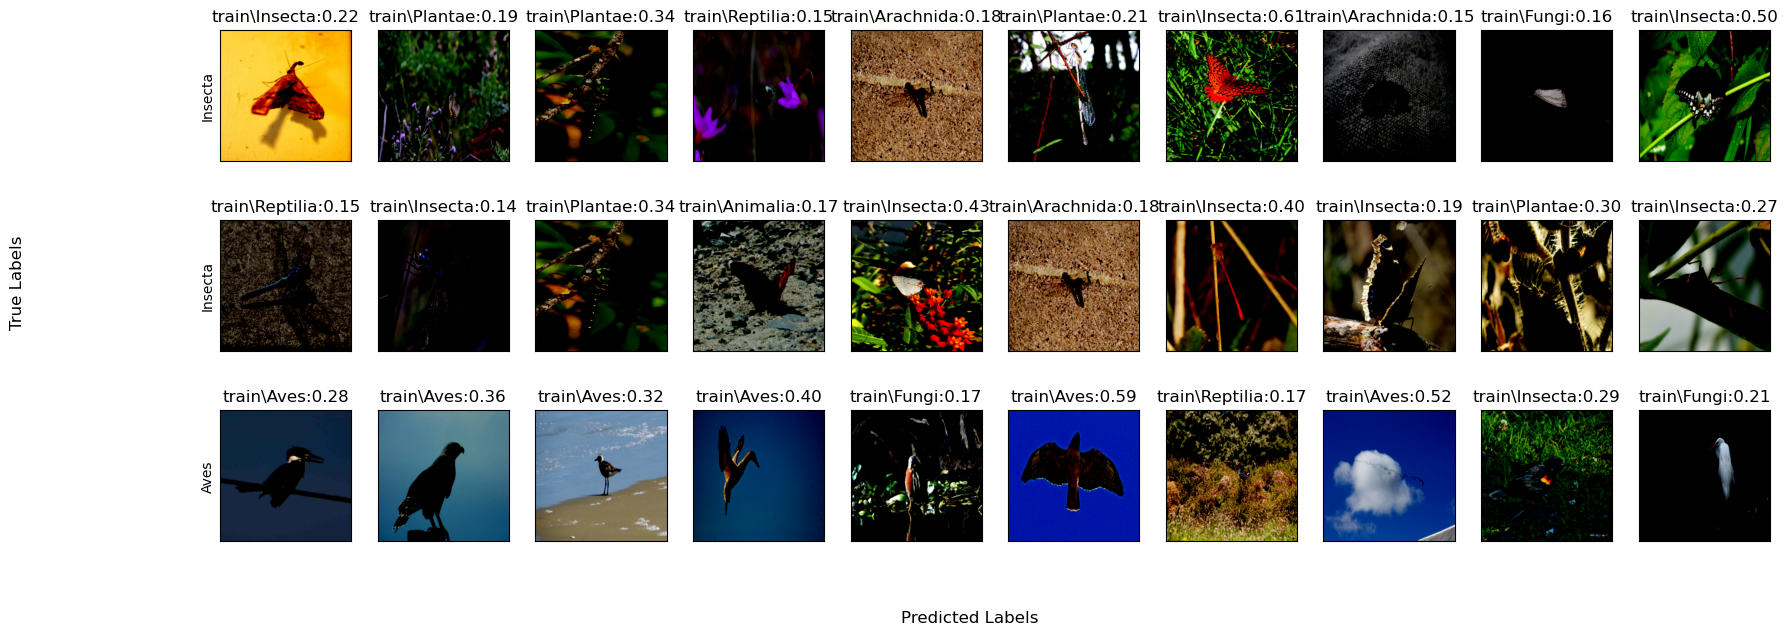

In [32]:
# Defining test transforms for augmentation
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
fig, axs = plt.subplots(3, 10, figsize=(20,7))

model.eval()
class_ = list(map(lambda x: x.split("/")[-1], glob.glob('D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train/*')))
idx=list(range(len(class_)))
label_dict=dict(zip(idx,class_))
for i in range(3):
            classes = random.sample(os.listdir('D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val'), k=3)
            path = os.path.join('D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val', classes[i])
            img_path = random.sample(os.listdir(path), 10)
            
            
            imgs = [test_transforms(Image.open(os.path.join(path,i)).convert('RGB')) for i in img_path]
            for c, img in enumerate(imgs):
                    optimizer.zero_grad()
                    if train_on_gpu:
                         img_input = img.to(device)
                    pred = nn.functional.softmax(model(img_input.unsqueeze(0)), dim=1)
                    prob, idx = torch.max(pred,dim=1)
                    axs[i, c].set_title(f"{label_dict[idx.item()]}:{prob.item():0.2f}")
                    axs[i, c].imshow(img.permute(1,2,0).numpy())
                    axs[i, c].set(ylabel=classes[i])
                    axs[i, c].set_xticks([])
                    axs[i, c].set_yticks([])
                    
            
for ax in axs.flat:
     ax.label_outer()
fig.supylabel("True Labels")
fig.supxlabel("Predicted Labels")
plt.savefig("./1.png")
# wandb.log({f"Question-4": wandb.Image(Image.open("./1.png").convert("RGB"))})
plt.show()